# Baseline models

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import LSTM, Convolution1D, GlobalAveragePooling1D, Dense, Dropout
import keras_tuner as kt

from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import RandomizedSearchCV

# Check for TensorFlow GPU access
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")

# See TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.9.2


In [19]:
train_data_df = pd.read_csv('../data_analysis/fd001/fd001-raw_train.csv', sep=' ')
test_data_df = pd.read_csv('../data_analysis/fd001/fd001-raw_test.csv', sep=' ')

train_labels_df = pd.read_csv('../data_analysis/fd001/fd001-training_labels.csv', sep=' ')
test_labels_df = pd.read_csv('../data_analysis/fd001/fd001-testing_labels.csv', sep=' ')
test_labels_at_break_df = pd.DataFrame(pd.read_csv('../TED/CMAPSSData/RUL_FD001.txt', sep=' ', header=None)[0])
test_labels_at_break_df.columns = ['RUL']

In [20]:
test_at_break_df = test_data_df.groupby(['ID'], sort=False).last().reset_index()
train_labels_df = train_labels_df.clip(upper = 125)
# test_labels_df = test_labels_df.clip(upper = 125)

### Windows extraction

In [21]:
def get_windows(data_df, labels_df, window_length, mode = 'train'):

    if mode == 'train':

        labels_df['ID'] = data_df['ID']

        data_groupby = data_df.groupby('ID', sort=False)
        labels_groupby = labels_df.groupby('ID', sort=False)

        val_indices = np.random.choice(len(data_groupby), size = int(0.2 * len(data_groupby)))

        tr_data_eng_arr = []
        tr_labels_eng_arr = []

        val_data_eng_arr = []
        val_labels_eng_arr = []

        for i in range(len(data_groupby)):
            if i in val_indices:
                val_data_eng_arr.append(data_groupby.get_group(i+1))
            else:
                tr_data_eng_arr.append(data_groupby.get_group(i+1))

        for i in range(len(labels_groupby)):
            if i in val_indices:
                val_labels_eng_arr.append(labels_groupby.get_group(i+1))
            else:
                tr_labels_eng_arr.append(labels_groupby.get_group(i+1))

        tr_data_windows = []
        tr_label_windows = []
        for index in range(len(tr_data_eng_arr)):
            tr_data_arr = tr_data_eng_arr[index].to_numpy()
            tr_labels_arr = tr_labels_eng_arr[index].to_numpy()
            for t in range(tr_data_arr.shape[0] - window_length + 1):
                tr_data_windows.append(tr_data_arr[t:t+window_length, :])
                tr_label_windows.append(tr_labels_arr[t+window_length - 1])

        val_data_windows = []
        val_label_windows = []
        for index in range(len(val_data_eng_arr)):
            val_data_arr = val_data_eng_arr[index].to_numpy()
            val_labels_arr = val_labels_eng_arr[index].to_numpy()
            for t in range(val_data_arr.shape[0] - window_length + 1):
                val_data_windows.append(val_data_arr[t:t+window_length, :])
                val_label_windows.append(val_labels_arr[t+window_length - 1])

        return np.array(tr_data_windows), np.array(tr_label_windows), np.array(val_data_windows), np.array(val_label_windows)

    else:

        labels_df['ID'] = data_df['ID']

        data_groupby = data_df.groupby('ID', sort=False)
        labels_groupby = labels_df.groupby('ID', sort=False)
        data_eng_arr = []
        labels_eng_arr = []

        for i in range(len(data_groupby)):
            data_eng_arr.append(data_groupby.get_group(i+1))

        for i in range(len(labels_groupby)):
            labels_eng_arr.append(labels_groupby.get_group(i+1))

        data_windows = []
        label_windows = []
        for index in range(len(data_eng_arr)):
            data_arr = data_eng_arr[index].to_numpy()
            labels_arr = labels_eng_arr[index].to_numpy()
            data_windows.append(data_arr[-window_length:, :])
            label_windows.append(labels_arr[-1, 0])

        return np.array(data_windows), np.array(label_windows)

### Divide train set between train and validation sets

In [22]:
train_labels_df['ID'] = train_data_df['ID']

In [23]:
train_groupby_df = train_data_df.groupby(['ID'], sort = False)
train_labels_groupby_df = train_labels_df.groupby(['ID'], sort = False)
val_indices = np.random.choice(len(train_groupby_df), size = int(0.2 * len(train_groupby_df)))

train_labels_df = train_labels_df['RUL']

val_arr = []
train_set_arr = []
val_labels_arr = []
train_set_labels_arr = []

for i in range(len(train_groupby_df)):
    if i in val_indices:
        val_arr.append(train_groupby_df.get_group(i+1))
        val_labels_arr.append(train_labels_groupby_df.get_group(i+1)['RUL'])
    else:
        train_set_arr.append(train_groupby_df.get_group(i+1))
        train_set_labels_arr.append(train_labels_groupby_df.get_group(i+1)['RUL'])

val_set_df = val_arr[0]
val_labels_df = val_labels_arr[0]
for i in range(1, len(val_arr)):
    val_set_df = pd.concat([val_set_df, val_arr[i]])
    val_labels_df = pd.concat([val_labels_df, val_labels_arr[i]])

train_set_df = train_set_arr[0]
train_set_labels_df = train_set_labels_arr[0]
for i in range(1, len(train_set_arr)):
    train_set_df = pd.concat([train_set_df, train_set_arr[i]])
    train_set_labels_df = pd.concat([train_set_labels_df, train_set_labels_arr[i]])

train_set = train_set_df.values
train_set_labels = train_set_labels_df.values
val_set = val_set_df.values
val_labels = val_labels_df.values
val_labels = np.expand_dims(val_labels, axis = 1)
train_set_labels = np.expand_dims(train_set_labels, axis = 1)
train_labels = np.expand_dims(train_labels_df.values, axis = 1)

In [24]:
ms_used = train_data_df.columns[2:]
ms_used

Index(['SensorMeasure2', 'SensorMeasure3', 'SensorMeasure4', 'SensorMeasure7',
       'SensorMeasure8', 'SensorMeasure11', 'SensorMeasure12',
       'SensorMeasure13', 'SensorMeasure15', 'SensorMeasure17',
       'SensorMeasure20', 'SensorMeasure21'],
      dtype='object')

## Survival Analysis: KaplanMeierFitter and CoxPHFitter

### Kaplan Meier Fitter

In [25]:
km_train = train_data_df.copy()
km_test = test_data_df.copy()
km_train['Event Observed'] = 1
km_test['Event Observed'] = 0

km_total = pd.concat([km_train, km_test])

<AxesSubplot:xlabel='timeline'>

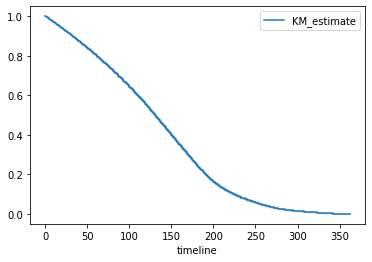

In [26]:
kmf = KaplanMeierFitter()
kmf.fit(durations = km_total['Cycle'], event_observed = km_total['Event Observed'])
kmf.plot_survival_function()

In [27]:
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print(median_)
print(median_confidence_interval_)

131.0
     KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                   130.0                   132.0


### Cox Proportional Hazard

In [28]:
cox_train = train_data_df.copy()
cox_test = test_data_df.copy()
cox_train['Event Observed'] = 1
cox_test['Event Observed'] = 0

cox_total = pd.concat([cox_train, cox_test])

In [29]:
cph = CoxPHFitter()
cph.fit(cox_total, duration_col = 'Cycle', event_col = 'Event Observed')
cph.print_summary()

/Users/henry/.virtualenvs/tf-m1/lib/python3.9/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 33727 total observations, 13096 right-censored observations>
             duration col = 'Cycle'
                event col = 'Event Observed'
      baseline estimation = breslow
   number of observations = 33727
number of events observed = 20631
   partial log-likelihood = -187026.51
         time fit was run = 2022-08-07 20:03:18 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
ID               -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
SensorMeasure2   -0.09       0.91       0.02            -0.14            -0.05                 0.87                 0.95
SensorMeasure3   -0.01       0.99       0.00            -0.01            -0.01                 0.99                 0.99
SensorMeasure4   -0.02       0.98       0.00            -0.02            -0.01                 0.98                 0.99
SensorMeasure7    0.10       1.11       0.02             0.07             0.13                 1.07                 1.14
SensorMeasure8    2.11       8.26       0.20             1.73             2.50                 5.62                12.13
SensorMeasure11  -0.70       0.49       0.06            -0.83            -0.58                 0.44                 0.56
SensorMeasure12   0.15       1.16       0.02             0.11             0.19                 1.12                 1.21
SensorMeasure13   1.83       6.22       0.19             1.45             2.21                 4.25                 9.10
SensorMeasure15  -2.24       0.11       0.34            -2.90            -1.58                 0.05                 0.20
SensorMeasure17  -0.07       0.94       0.01            -0.08            -0.05                 0.92                 0.95
SensorMeasure20   0.61       1.83       0.07             0.48             0.74                 1.61                 2.09
SensorMeasure21   0.97       2.63       0.11             0.75             1.19                 2.11                 3.28

                  cmp to      z      p   -log2(p)
covariate                                        
ID                  0.00 -11.32 <0.005      96.27
SensorMeasure2      0.00  -4.16 <0.005      14.92
SensorMeasure3      0.00  -6.75 <0.005      35.96
SensorMeasure4      0.00  -9.32 <0.005      66.19
SensorMeasure7      0.00   6.07 <0.005      29.51
SensorMeasure8      0.00  10.76 <0.005      87.27
SensorMeasure11     0.00 -11.09 <0.005      92.45
SensorMeasure12     0.00   7.14 <0.005      39.91
SensorMeasure13     0.00   9.40 <0.005      67.37
SensorMeasure15     0.00  -6.67 <0.005      35.18
SensorMeasure17     0.00  -9.25 <0.005      65.22
SensorMeasure20     0.00   9.08 <0.005      63.01
SensorMeasure21     0.00   8.59 <0.005      56.66
---
Concordance = 0.71
Partial AIC = 374079.02
log-likelihood ratio test = 7191.40 on 13 df
-log2(p) of ll-ratio test = inf

<AxesSubplot:xlabel='log(HR) (95% CI)'>

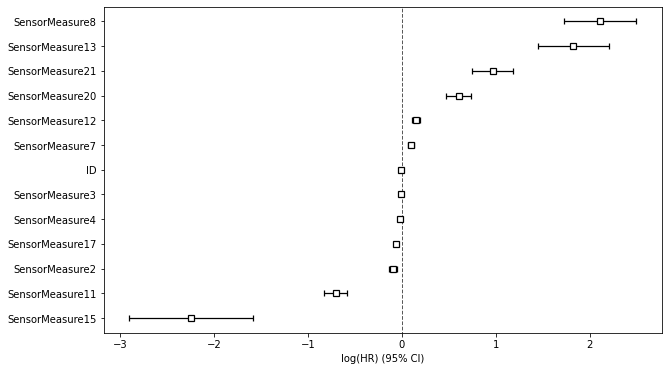

In [30]:
plt.subplots(figsize = (10, 6))
cph.plot()

## Random Forest Regressor

In [31]:
# rf_param_grid = {
#     'bootstrap': [True, False], 
#     'max_depth': [6, 7, 8, 9, 10], 
#     'min_samples_leaf': [30, 35, 40, 45, 50],
#     'max_features': ['log2', 'sqrt'], 
#     'n_estimators': [100 * x for x in range(5, 11)],
#     }

# rf = RandomForestRegressor(random_state=42)
# rand_search_rf = RandomizedSearchCV(estimator = rf, param_distributions = rf_param_grid, cv = 3, n_jobs = 1, verbose = 3, return_train_score=True)
# rand_search_rf.fit(train_data_df[ms_used].values, train_labels_df.values.squeeze())
# rf_results = pd.DataFrame(rand_search_rf.cv_results_)

# predictions_rf = rand_search_rf.predict(test_at_break_df[ms_used].values).round()
# print(rand_search_rf.best_params_)
# rmse = np.sqrt(mean_squared_error(test_labels_at_break_df.values, predictions_rf))
# print("RMSE: " + str(rmse)) 

In [32]:
train_data_df[ms_used]

,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure7,SensorMeasure8,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure15,SensorMeasure17,SensorMeasure20,SensorMeasure21
0,641.82,1589.70,1400.60,554.36,2388.06,47.47,521.66,2388.02,8.4195,392,39.06,23.4190
1,642.15,1591.82,1403.14,553.75,2388.04,47.49,522.28,2388.07,8.4318,392,39.00,23.4236
2,642.35,1587.99,1404.20,554.26,2388.08,47.27,522.42,2388.03,8.4178,390,38.95,23.3442
3,642.35,1582.79,1401.87,554.45,2388.11,47.13,522.86,2388.08,8.3682,392,38.88,23.3739
4,642.37,1582.85,1406.22,554.00,2388.06,47.28,522.19,2388.04,8.4294,393,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...
20626,643.49,1597.98,1428.63,551.43,2388.19,48.07,519.49,2388.26,8.4956,397,38.49,22.9735
20627,643.54,1604.50,1433.58,550.86,2388.23,48.04,519.68,2388.22,8.5139,395,38.30,23.1594
20628,643.42,1602.46,1428.18,550.94,2388.24,48.09,520.01,2388.24,8.5646,398,38.44,22.9333
20629,643.23,1605.26,1426.53,550.68,2388.25,48.39,519.67,2388.23,8.5389,395,38.29,23.0640


In [33]:
best_rf = RandomForestRegressor(n_estimators=100, max_features="sqrt", random_state=42, max_depth=8, min_samples_leaf=50)
best_rf.fit(train_data_df[ms_used].values, train_labels_df.values.squeeze())
predictions_rf = best_rf.predict(test_at_break_df[ms_used].values).round()
rmse = np.sqrt(mean_squared_error(test_labels_at_break_df.values, predictions_rf))
print("RMSE: " + str(rmse)) 

RMSE: 20.969978540761552


## Gradient Boosting Regressor

In [ ]:
# gb_params = {
#     'learning_rate': [0.001, 0.05, 0.1, 0.2, 0.3],
#     'n_estimators': [100 * x for x in range(5, 11)],
#     'subsample': [0.75, 0.85, 0.95, 1],
#     'min_samples_leaf': [30, 35, 40, 45, 50],
# }

# gb = GradientBoostingRegressor()
# rand_search_gb = RandomizedSearchCV(estimator = gb, param_distributions = gb_params, cv = 3, n_jobs = 1, verbose = 3, return_train_score=True)
# rand_search_gb.fit(train_data_df.values[:,1:], train_labels_df['RUL'].values.squeeze())

# predictions_gb = rand_search_gb.predict(test_at_break_df.values[:,1:]).round()
# print(rand_search_gb.best_params_)
# rmse = np.sqrt(mean_squared_error(test_labels_at_break_df.values, predictions_gb))
# print("RMSE: " + str(rmse)) 

In [62]:
best_gb = GradientBoostingRegressor(random_state=42, n_estimators = 900, min_samples_leaf = 40, max_features = 'sqrt', max_depth = 10)
best_gb.fit(train_data_df[ms_used].values, train_labels_df.values.squeeze())
predictions_gb = best_gb.predict(test_at_break_df[ms_used].values).round()
rmse = np.sqrt(mean_squared_error(test_labels_at_break_df.values, predictions_gb))
print("RMSE: " + str(rmse)) 

RMSE: 19.847417968088443


## Support Vector Regressor

In [ ]:
# svmr_params = {
#     'kernel': ['rbf', 'linear', 'poly'],
#     'C': [1, 2, 5, 10],
#     'epsilon': [0.1 * i for i in range(1, 6)]
# }

# svmr = SVR()
# rand_search_svmr = RandomizedSearchCV(estimator = svmr, param_distributions = svmr_params, cv = 3, n_jobs = 1, verbose = 3, return_train_score=True)
# rand_search_svmr.fit(train_data_df[ms_used].values, train_labels_df.values.squeeze())

# predictions_svmr = rand_search_svmr.predict(test_at_break_df[ms_used].values).round()
# print(rand_search_svmr.best_params_)
# rmse = np.sqrt(mean_squared_error(test_labels_at_break_df.values, predictions_svmr))
# print("RMSE: " + str(rmse)) 

In [120]:
best_svmr = SVR(C = 1, epsilon = 0.0)
best_svmr.fit(train_data_df[ms_used].values, train_labels_df.values.squeeze())
predictions_svmr = best_svmr.predict(test_at_break_df[ms_used].values).round()
rmse = np.sqrt(mean_squared_error(test_labels_at_break_df.values, predictions_svmr))
print("RMSE: " + str(rmse)) 

RMSE: 43.80096110302132


## Multi Layer Perceptron - Neural Network

In [51]:
window_length = 20
mlp_tr_data, mlp_tr_labels, mlp_val_data, mlp_val_labels = get_windows(train_data_df, train_labels_df, window_length, mode='train')
mlp_test_data, mlp_test_labels = get_windows(test_data_df, test_labels_df, window_length, mode = 'test')

mlp_tr_data = mlp_tr_data.reshape(mlp_tr_data.shape[0], -1)
mlp_val_data = mlp_val_data.reshape(mlp_val_data.shape[0], -1)
mlp_test_data = mlp_test_data.reshape(mlp_test_data.shape[0], -1)

mlp_tr_labels = np.expand_dims(mlp_tr_labels, axis=1)
mlp_val_labels = np.expand_dims(mlp_val_labels, axis=1)
mlp_test_labels = np.expand_dims(mlp_test_labels, axis=1)

In [54]:
def mlp_model_builder(hp):

    hp_units1 = hp.Int('units1', min_value=32, max_value=128, step=32)
    hp_units2 = hp.Int('units2', min_value=32, max_value=128, step=32)
    hp_units3 = hp.Int('units3', min_value=32, max_value=128, step=32)

    hp_dropout = hp.Choice('dropout_rate', values=[0.1, 0.2, 0.3, 0.4])
    hp_learning_rate = hp.Choice('learning_rate', values=[0.001, 0.005, 0.01, 0.05])

    mlp_model = Sequential()
    mlp_model.add(Dense(units = hp_units1, activation = 'relu', input_dim = mlp_tr_data.shape[1]))
    mlp_model.add(Dropout(hp_dropout))
    mlp_model.add(Dense(units = hp_units2, activation = 'relu'))
    mlp_model.add(Dropout(hp_dropout))
    mlp_model.add(Dense(units = hp_units3 , activation = 'relu'))
    mlp_model.add(Dropout(hp_dropout))
    mlp_model.add(Dense(1, activation = 'relu'))

    mlp_model.compile(optimizer=keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss=keras.losses.MeanSquaredError())

    return mlp_model

mlp_tuner = kt.BayesianOptimization(mlp_model_builder,
                                    objective='val_loss',
                                    max_trials = 9,
                                    directory='baseline_models',
                                    project_name='mlp')

INFO:tensorflow:Reloading Oracle from existing project baseline_models/mlp/oracle.json
INFO:tensorflow:Reloading Tuner from baseline_models/mlp/tuner0.json


In [36]:
mlp_tuner.search(train_set_df[ms_used].values, train_set_labels.squeeze(), epochs=100, validation_data = (val_set_df[ms_used].values, val_labels.squeeze()), batch_size = 256)
best_mlp_hps = mlp_tuner.get_best_hyperparameters(num_trials=1)[0]

best_mlp_model = mlp_tuner.hypermodel.build(best_mlp_hps)
mlp_history = best_mlp_model.fit(train_set_df[ms_used].values, train_set_labels.squeeze(), epochs=100, validation_data = (val_set_df[ms_used].values, val_labels.squeeze()), batch_size = 256)


Search: Running Trial #5

Value             |Best Value So Far |Hyperparameter
128               |128               |units1
32                |32                |units2
128               |32                |units3
0.1               |0.1               |dropout_rate
0.001             |0.001             |learning_rate

Epoch 1/100


2022-07-29 00:27:52.768364: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


ValueError: in user code:

    File "/Users/henry/.virtualenvs/tf-m1/lib/python3.9/site-packages/keras/engine/training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "/Users/henry/.virtualenvs/tf-m1/lib/python3.9/site-packages/keras/engine/training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/henry/.virtualenvs/tf-m1/lib/python3.9/site-packages/keras/engine/training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "/Users/henry/.virtualenvs/tf-m1/lib/python3.9/site-packages/keras/engine/training.py", line 889, in train_step
        y_pred = self(x, training=True)
    File "/Users/henry/.virtualenvs/tf-m1/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/henry/.virtualenvs/tf-m1/lib/python3.9/site-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 360), found shape=(None, 16)


In [ ]:
# PLOT TRAIN AND VALIDATION LOSS
def plot_loss(fit_history):
    plt.figure(figsize=(13,5))
    plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
    plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(mlp_history)

In [ ]:
# TESTING FUNCTION
def testing(actual, pred, mode = 'Test'):
    mse = mean_squared_error(actual, pred)
    rmse = np.sqrt(mse)
    variance = r2_score(actual, pred)
    print(mode + ' set RMSE: ' + str(rmse) + ', R2: ' + str(variance))

In [ ]:
train_full_pred = best_mlp_model.predict(mlp_tr_data)
testing(mlp_tr_labels, train_full_pred, 'Train')

test_at_break_pred = best_mlp_model.predict(mlp_test_data)
testing(mlp_test_labels, test_at_break_pred)

In [ ]:
train_full_pred = best_mlp_model.predict(train_data_df[ms_used].values)
testing(train_labels_df.values.squeeze(), train_full_pred, 'Train')

test_at_break_pred = best_mlp_model.predict(test_at_break_df[ms_used].values)
testing(test_labels_at_break_df.values.squeeze(), test_at_break_pred)

## Convolutional Neural Network

In [ ]:
window_length = 20
cnn_tr_data, cnn_tr_labels, cnn_val_data, cnn_val_labels = get_windows(train_data_df, train_labels_df, window_length, mode='train')
cnn_test_data, cnn_test_labels = get_windows(test_data_df, test_labels_df, 20, mode = 'test')

cnn_tr_labels = np.expand_dims(cnn_tr_labels, axis=1)
cnn_val_labels = np.expand_dims(cnn_val_labels, axis=1)
cnn_test_labels = np.expand_dims(cnn_test_labels, axis=1)

### Model

In [ ]:
cnn_model = Sequential()
cnn_model.add(Convolution1D(256, 3, input_shape = (window_length, cnn_tr_data.shape[2])))
cnn_model.add(Convolution1D(128, 3, activation = 'relu'))
cnn_model.add(Convolution1D(64, 3, activation = 'relu'))
cnn_model.add(GlobalAveragePooling1D(data_format = 'channels_last', keepdims = False))
cnn_model.add(Dense(1, activation = 'relu'))

cnn_model.compile(loss='mean_squared_error', optimizer='adam')
cnn_model.save_weights('simple_lstm_weights.h5')

cnn_model.compile(loss='mean_squared_error', optimizer='adam')  
cnn_model.load_weights('simple_lstm_weights.h5')  

history = cnn_model.fit(cnn_tr_data, cnn_tr_labels,
                        validation_data=(cnn_val_data, cnn_val_labels),
                        epochs=50,
                        batch_size=128)

In [ ]:
# TESTING FUNCTION
def evaluate(actual, pred, mode = 'test'):
    mse = mean_squared_error(actual, pred)
    rmse = np.sqrt(mse)
    variance = r2_score(actual, pred)
    print(mode + ' set RMSE: ' + str(rmse) + ', R2: ' + str(variance))

In [ ]:
# TESTING
train_cnn_pred = cnn_model.predict(cnn_tr_data)
evaluate(cnn_tr_labels, train_cnn_pred, 'train')

test_cnn_pred = cnn_model.predict(cnn_test_data)
evaluate(cnn_test_labels, test_cnn_pred)

## LSTM Neural Network

In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(32, activation='tanh', input_shape=(window_length, cnn_tr_data.shape[2])))
lstm_model.add(Dense(1))

lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.save_weights('simple_lstm_weights.h5')

lstm_model.compile(loss='mean_squared_error', optimizer='adam')  
lstm_model.load_weights('simple_lstm_weights.h5')  

history = lstm_model.fit(cnn_tr_data, cnn_tr_labels,
                        validation_data=(cnn_val_data, cnn_val_labels),
                        epochs=50,
                        batch_size=128)

In [ ]:
# PLOT LOSS HISTORY
def plot_loss(fit_history):
    plt.figure(figsize=(13,5))
    plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
    plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history)

In [ ]:
# TESTING FUNCTION
def evaluate(actual, pred, mode = 'test'):
    mse = mean_squared_error(actual, pred)
    rmse = np.sqrt(mse)
    variance = r2_score(actual, pred)
    print(mode + ' set RMSE: ' + str(rmse) + ', R2: ' + str(variance))

In [ ]:
# TESTING
train_cnn_pred = lstm_model.predict(cnn_tr_data)
evaluate(cnn_tr_labels, train_cnn_pred, 'train')

test_cnn_pred = lstm_model.predict(cnn_test_data)
evaluate(cnn_test_labels, test_cnn_pred)